In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"]="4"
os.environ['EXP_DIR']='exps'

import matplotlib
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm
import os
import numpy as np
import torch
from sgdcollapse.exps.train import TrainExperiment
from matplotlib import pyplot as plt
from multiprocessing import Pool

import seaborn as sns

plt.style.use("default")
rc = {"figure.figsize": (3.2, 2.4), "figure.dpi": 200, "figure.constrained_layout.use": True, "axes.grid": True,
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.5, "grid.linewidth": 0.5,
      "xtick.major.width": 0.5, "ytick.major.width": 0.5, "xtick.major.size": 2.5, "ytick.major.size": 2.5,
      "axes.labelsize": "small", "axes.titlesize": "small", "xtick.labelsize": "small", "ytick.labelsize": "small",
      "axes.titlepad": 2, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1, "patch.linewidth": 0}
sns.set_theme(style="ticks", context="paper", palette=sns.color_palette("tab10"), rc=rc)

In [3]:
def in_synapses(W, b=None, dtype=None):
    """
    Computes sum of in synapses to next layer
    """
    if np.ndim(W) == 4:
        in_sum = np.sum(W, axis=(1, 2, 3), dtype=dtype)
    else:
        in_sum = np.sum(W, axis=1, dtype=dtype)
    if b is not None:
        in_sum += b
    return in_sum

def out_synapses(W, b=None, dtype=None):
    """
    Computes sum of out synapses from last layer
    """
    if np.ndim(W) == 4:
        out_sum = np.sum(W, axis=(0, 2, 3), dtype=dtype)
    else:
        out_sum = np.sum(W, axis=0, dtype=dtype)
    return out_sum

def compute_eff_rnk(w_cat,epsilon=1e-8):
    s=np.linalg.svd(w_cat,compute_uv=False)
    s=s/s.sum()
    eff_rk=-(s*np.log(s+epsilon)).sum()
    return eff_rk

def compute_ind_node(none_zero_node,threshold2,epsilon=1e-8,return_dict=False):
    n_non_zero=len(none_zero_node)
    same_list=[]
    for i,j in combinations(np.arange(n_non_zero),2):
        if 2*(np.linalg.norm(none_zero_node[i]-none_zero_node[j],axis=-1)**2)/(epsilon+np.linalg.norm(none_zero_node[i],axis=-1)**2+np.linalg.norm(none_zero_node[j],axis=-1)**2)<threshold2:
            same_list.append((i,j))
    dict_list=defaultdict(list)
    tempt_list=[]
    for i,j in same_list:
        if j in tempt_list:
            continue
        if i not in tempt_list:
            tempt_list.append(i)
        tempt_list.append(j)
        dict_list[i].append(j)
    for i in range(n_non_zero):
        if i in tempt_list:
            continue
        dict_list[i].append(i)
    n_none_ind=len(dict_list.keys())
    if return_dict:
        return n_none_ind,dict_list
    return n_none_ind

In [ ]:
meta_results=[]
threshold=10e-2
threshold2=10e-2
def help_fun(replicate):
    for lr in tqdm([0.01,0.02,0.05,0.1]):

        exp=TrainExperiment.create('../configs/cifar10_sgd/train_sce_gelu_lbn_final2.yaml',cli_args=False)
        exp.train_batch_size=256
        exp.optimizer.lr=lr
        exp.optimizer.weight_decay=0.0005
        state_dict=torch.load('../exps/'+exp.hash+'/replicate_%d/checkpoints/state_%dba.pt'%(replicate,100000),map_location=torch.device('cpu'))

        results=np.zeros([15,2])
        eff_rank=np.zeros(15)

        for layer_i in range(1,13):
            w1=state_dict['state']['model']['module.conv%d.weight'%layer_i].cpu().numpy()
            w2=state_dict['state']['model']['module.conv%d.bias'%layer_i].cpu().numpy()
            w3=state_dict['state']['model']['module.conv%d.weight'%(layer_i+1)].cpu().numpy()
            win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
            wout=np.swapaxes(w3,0,1).reshape(w3.shape[1],-1).T
            w_cat=np.concatenate([win,wout.T],-1)
            eff_rk=compute_eff_rnk(w_cat)
            zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
            none_zero_node=w_cat[~zero_node]
            n_none_ind=compute_ind_node(none_zero_node,threshold2)
            results[layer_i-1,0]=n_none_ind
            results[layer_i-1,1]=w1.shape[0]
            eff_rank[layer_i-1]=eff_rk


        layer_i=13
        w1=state_dict['state']['model']['module.conv%d.weight'%layer_i].cpu().numpy()
        w2=state_dict['state']['model']['module.conv%d.bias'%layer_i].cpu().numpy()
        w3=state_dict['state']['model']['module.fc14.weight'].cpu().numpy()
        win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
        wout=w3
        eff_rk=compute_eff_rnk(w_cat)
        zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
        none_zero_node=w_cat[~zero_node]
        n_none_ind=compute_ind_node(none_zero_node,threshold2)
        results[layer_i-1,0]=n_none_ind
        results[layer_i-1,1]=w1.shape[0]
        eff_rank[layer_i-1]=eff_rk

        for layer_i in [14,15]:
            w1=state_dict['state']['model']['module.fc%d.weight'%layer_i].cpu().numpy()
            w2=state_dict['state']['model']['module.fc%d.bias'%layer_i].cpu().numpy()
            w3=state_dict['state']['model']['module.fc%d.weight'%(layer_i+1)].cpu().numpy()
            win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
            wout=w3
            w_cat=np.concatenate([win,wout.T],-1)
            eff_rk=compute_eff_rnk(w_cat)
            zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
            none_zero_node=w_cat[~zero_node]
            n_none_ind=compute_ind_node(none_zero_node,threshold2)
            results[layer_i-1,0]=n_none_ind
            results[layer_i-1,1]=w1.shape[0]
            eff_rank[layer_i-1]=eff_rk
        meta_results.append(np.concatenate([results,eff_rank[:,None]],-1))
    return meta_results
with Pool(4) as p:
    results=p.map(help_fun,range(4))
results=np.array(results)
results_cifar_lr=results

100%|██████████| 4/4 [01:00<00:00, 15.07s/it]


In [120]:
meta_results=[]

threshold=10e-2
threshold2=10e-2

def help_fun(replicate):
    for sigma in tqdm([0.0,0.2,0.4,0.6,0.8]):

        exp=TrainExperiment.create('../configs/cifar10_sgd/train_sce_gelu_lbn_final3.yaml',cli_args=False)
        exp.train_batch_size=256
        exp.optimizer.lr=0.01
        exp.optimizer.weight_decay=0.0005
        exp.train_data.sigma=sigma

        state_dict=torch.load('../exps/'+exp.hash+'/replicate_%d/checkpoints/state_%dba.pt'%(replicate,1000000),map_location=torch.device('cpu'))

        results=np.zeros([15,2])
        eff_rank=np.zeros(15)

        for layer_i in range(1,13):
            w1=state_dict['state']['model']['module.conv%d.weight'%layer_i].cpu().numpy()
            w2=state_dict['state']['model']['module.conv%d.bias'%layer_i].cpu().numpy()
            w3=state_dict['state']['model']['module.conv%d.weight'%(layer_i+1)].cpu().numpy()
            win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
            wout=np.swapaxes(w3,0,1).reshape(w3.shape[1],-1).T
            w_cat=np.concatenate([win,wout.T],-1)
            eff_rk=compute_eff_rnk(w_cat)

            zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
            none_zero_node=w_cat[~zero_node]
            n_none_ind=compute_ind_node(none_zero_node,threshold2)
            results[layer_i-1,0]=n_none_ind
            results[layer_i-1,1]=w1.shape[0]
            eff_rank[layer_i-1]=eff_rk

        layer_i=13
        w1=state_dict['state']['model']['module.conv%d.weight'%layer_i].cpu().numpy()
        w2=state_dict['state']['model']['module.conv%d.bias'%layer_i].cpu().numpy()
        w3=state_dict['state']['model']['module.fc14.weight'].cpu().numpy()
        win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
        wout=w3
        eff_rk=compute_eff_rnk(w_cat)
        zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
        none_zero_node=w_cat[~zero_node]
        n_none_ind=compute_ind_node(none_zero_node,threshold2)
        results[layer_i-1,0]=n_none_ind
        results[layer_i-1,1]=w1.shape[0]
        eff_rank[layer_i-1]=eff_rk

        for layer_i in [14,15]:
            w1=state_dict['state']['model']['module.fc%d.weight'%layer_i].cpu().numpy()
            w2=state_dict['state']['model']['module.fc%d.bias'%layer_i].cpu().numpy()
            w3=state_dict['state']['model']['module.fc%d.weight'%(layer_i+1)].cpu().numpy()
            win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
            wout=w3
            w_cat=np.concatenate([win,wout.T],-1)
            eff_rk=compute_eff_rnk(w_cat)
            zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
            none_zero_node=w_cat[~zero_node]
            n_none_ind=compute_ind_node(none_zero_node,threshold2)
            results[layer_i-1,0]=n_none_ind
            results[layer_i-1,1]=w1.shape[0]
            eff_rank[layer_i-1]=eff_rk
        meta_results.append(np.concatenate([results,eff_rank[:,None]],-1))
    return meta_results
with Pool(4) as p:
    results=p.map(help_fun,range(4))
results=np.array(results)
results_cifar_sigma=results

100%|██████████| 5/5 [00:52<00:00, 10.43s/it]


In [123]:
meta_results=[]
threshold=0.1
threshold2=0.1

bn_layer_names=[None,'module.bn1',
                'module.layer1.0.bn1','module.layer1.0.bn2',
                'module.layer1.1.bn1','module.layer1.1.bn2',
                'module.layer2.0.bn1','module.layer2.0.bn2',
                'module.layer2.1.bn1','module.layer2.1.bn2',
                 'module.layer3.0.bn1','module.layer3.0.bn2',
                'module.layer4.1.bn1','module.layer4.1.bn2']
weight_names=['module.conv1.weight',
              'module.layer1.0.conv1.weight','module.layer1.0.conv2.weight',
              'module.layer1.1.conv1.weight','module.layer1.1.conv2.weight',
              'module.layer2.0.conv1.weight','module.layer2.0.conv2.weight',
              'module.layer2.1.conv1.weight','module.layer2.1.conv2.weight',
              'module.layer3.0.conv1.weight','module.layer3.0.conv2.weight',
              'module.layer3.1.conv1.weight','module.layer3.1.conv2.weight',
              'module.layer4.0.conv1.weight','module.layer4.0.conv2.weight',
              'module.layer4.1.conv1.weight','module.layer4.1.conv2.weight','module.fc.weight']

def help_fun(replicate):
    for sigma in tqdm([0.0,0.2,0.4,0.6,0.8]):

        exp=TrainExperiment.create('../configs/cifar100_sgd/train_sce_gelu_resnet.yaml',cli_args=False)
        exp.max_duration='1000000ba'
        exp.train_batch_size=256
        exp.optimizer.lr=0.02
        exp.optimizer.weight_decay=0.0005
        exp.train_data.sigma=sigma

        state_dict=torch.load('../exps/'+exp.hash+'/replicate_%d/checkpoints/state_%dba.pt'%(replicate,1000000),map_location=torch.device('cpu'))

        results=np.zeros([17,2])
        eff_rank=np.zeros(17)
        
        for layer_i in range(len(weight_names)-1):
            w1=state_dict['state']['model'][weight_names[layer_i]].cpu().numpy()
            w2=state_dict['state']['model'][weight_names[layer_i+1]].cpu().numpy()
            win=w1.reshape(w1.shape[0],-1)
            wout=np.swapaxes(w2,0,1).reshape(w2.shape[1],-1).T
            w_cat=np.concatenate([win,wout.T],-1)
            
            eff_rk=compute_eff_rnk(w_cat)
            zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
            none_zero_node=w_cat[~zero_node]
            n_none_ind=compute_ind_node(none_zero_node,threshold2)
            results[layer_i-1,0]=n_none_ind
            results[layer_i-1,1]=w1.shape[0]
            eff_rank[layer_i-1]=eff_rk
        meta_results.append(np.concatenate([results,eff_rank[:,None]],-1))
    return meta_results

with Pool(4) as p:
    results=p.map(help_fun,range(4))
results=np.array(results)
results_cifar100_sigma=results

100%|██████████| 5/5 [00:58<00:00, 11.65s/it]


In [128]:
meta_results=[]
threshold=0.1
threshold2=0.1

bn_layer_names=[None,'module.bn1',
                'module.layer1.0.bn1','module.layer1.0.bn2',
                'module.layer1.1.bn1','module.layer1.1.bn2',
                'module.layer2.0.bn1','module.layer2.0.bn2',
                'module.layer2.1.bn1','module.layer2.1.bn2',
                 'module.layer3.0.bn1','module.layer3.0.bn2',
                'module.layer4.1.bn1','module.layer4.1.bn2']
weight_names=['module.conv1.weight',
              'module.layer1.0.conv1.weight','module.layer1.0.conv2.weight',
              'module.layer1.1.conv1.weight','module.layer1.1.conv2.weight',
              'module.layer2.0.conv1.weight','module.layer2.0.conv2.weight',
              'module.layer2.1.conv1.weight','module.layer2.1.conv2.weight',
              'module.layer3.0.conv1.weight','module.layer3.0.conv2.weight',
              'module.layer3.1.conv1.weight','module.layer3.1.conv2.weight',
              'module.layer4.0.conv1.weight','module.layer4.0.conv2.weight',
              'module.layer4.1.conv1.weight','module.layer4.1.conv2.weight','module.fc.weight']

def help_fun(replicate):
    for lr in tqdm([0.01,0.02,0.05,0.1]):

        exp=TrainExperiment.create('../configs/cifar100_sgd/train_sce_gelu_resnet.yaml',cli_args=False)
        exp.max_duration='500000ba'
        exp.train_batch_size=256
        exp.optimizer.lr=lr
        exp.optimizer.weight_decay=0.0005
        exp.train_data.sigma=0.0

        state_dict=torch.load('../exps/'+exp.hash+'/replicate_%d/checkpoints/state_%dba.pt'%(replicate,100000),map_location=torch.device('cpu'))

        results=np.zeros([17,2])
        eff_rank=np.zeros(17)
        
        for layer_i in range(len(weight_names)-1):
            w1=state_dict['state']['model'][weight_names[layer_i]].cpu().numpy()
            w2=state_dict['state']['model'][weight_names[layer_i+1]].cpu().numpy()
            win=w1.reshape(w1.shape[0],-1)
            wout=np.swapaxes(w2,0,1).reshape(w2.shape[1],-1).T
            w_cat=np.concatenate([win,wout.T],-1)
            
            eff_rk=compute_eff_rnk(w_cat)
            zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
            none_zero_node=w_cat[~zero_node]
            n_none_ind=compute_ind_node(none_zero_node,threshold2)
            results[layer_i-1,0]=n_none_ind
            results[layer_i-1,1]=w1.shape[0]
            eff_rank[layer_i-1]=eff_rk
        meta_results.append(np.concatenate([results,eff_rank[:,None]],-1))
    return meta_results

with Pool(4) as p:
    results=p.map(help_fun,range(4))
results=np.array(results)
results_cifar100_lr=results

100%|██████████| 4/4 [01:49<00:00, 27.28s/it]


/var/tmp/ipykernel_24619/3408023410.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('autumn', 9)
/var/tmp/ipykernel_24619/3408023410.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('winter', 5)
/var/tmp/ipykernel_24619/3408023410.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('autumn', 9)
/var/tmp/ipykernel_24619/3408023410.py:55: MatplotlibDeprecationWarning: The get_cmap 

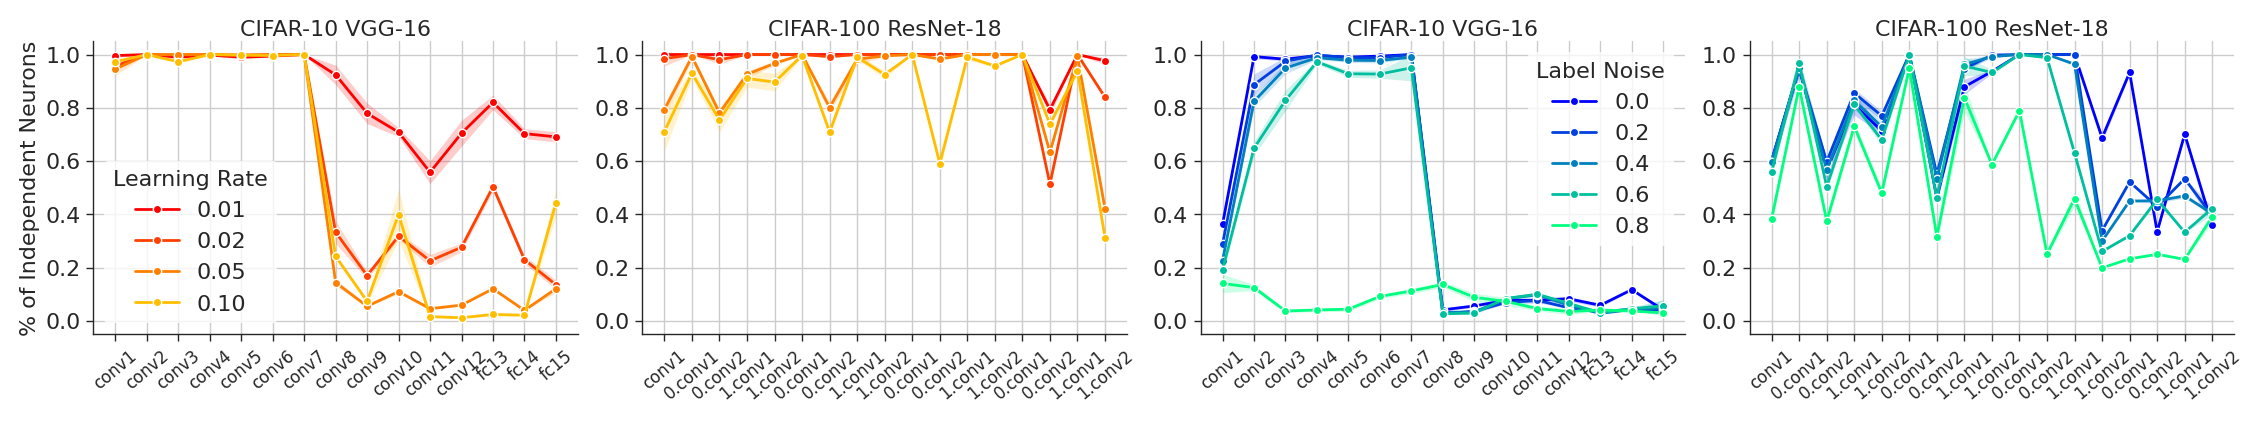

In [158]:
fig, axes = plt.subplots(1,4,figsize=(2.8*4, 2.0), width_ratios=[1, 1, 1, 1])


cmap = matplotlib.cm.get_cmap('autumn', 9)
results=results_cifar_lr

for i,j in enumerate([0.01,0.02,0.05,0.1]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[0].plot(np.arange(15),y.mean(axis=0),marker='o', ms=3, mec="white", mew=0.5,color=cmap(2*i),label='%1.2f'%j)
    axes[0].fill_between(np.arange(15),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=cmap(2*i))
axes[0].set_ylabel(r'% of Independent Neurons')
axes[0].set_ylim(-0.05,1.05)
axes[0].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
axes[0].tick_params(axis='x', which='major', labelsize=6)
axes[0].set_xticklabels(['conv%d'%i for i in range(1,13)]+['fc13','fc14','fc15'],rotation=40)
axes[0].legend(title='Learning Rate', fontsize=8, title_fontsize=8)
axes[0].set_title("CIFAR-10 VGG-16")

cmap = matplotlib.cm.get_cmap('winter', 5)
results=results_cifar_sigma

for i,j in enumerate([0.0,0.2,0.4,0.6,0.8]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[2].plot(np.arange(15),y.mean(axis=0),marker='o', ms=3, mec="white", mew=0.5,color=cmap(i),label='%0.1f'%j)
    axes[2].fill_between(np.arange(15),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=cmap(i))
axes[2].set_ylim(-0.05,1.05)
axes[2].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
axes[2].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
axes[2].tick_params(axis='x', which='major', labelsize=6)
axes[2].set_xticklabels(['conv%d'%i for i in range(1,13)]+['fc13','fc14','fc15'],rotation=40)
axes[2].legend(title='Label Noise', fontsize=8, title_fontsize=8,loc="upper right")
axes[2].set_title("CIFAR-10 VGG-16")

cmap = matplotlib.cm.get_cmap('autumn', 9)
results=results_cifar100_lr
for i,j in enumerate([0.01,0.02,0.05,0.1]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[1].plot(np.arange(17),y.mean(axis=0),color=cmap(2*i),marker='o', ms=3, mec="white", mew=0.5)
    axes[1].fill_between(np.arange(17),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=cmap(2*i))
axes[1].set_ylim(-0.05,1.05)
axes[1].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
axes[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
axes[1].tick_params(axis='x', which='major', labelsize=6)
axes[1].set_xticklabels(['conv1','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2'],rotation=40)
axes[1].set_title("CIFAR-100 ResNet-18")

cmap = matplotlib.cm.get_cmap('winter', 5)
results=results_cifar100_sigma
for i,j in enumerate([0.0,0.2,0.4,0.6,0.8]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[3].plot(np.arange(17),y.mean(axis=0),color=cmap(i),marker='o', ms=3, mec="white", mew=0.5)
    axes[3].fill_between(np.arange(17),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=cmap(i))
axes[3].set_ylim(-0.05,1.05)
axes[3].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
axes[3].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
axes[3].tick_params(axis='x', which='major', labelsize=6)
axes[3].set_xticklabels(['conv1','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2'],rotation=40)
axes[3].set_title("CIFAR-100 ResNet-18")

plt.savefig('Fig_2.2.pdf',bbox_inches='tight')

/var/tmp/ipykernel_24619/164317028.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('autumn', 9)
/var/tmp/ipykernel_24619/164317028.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('winter', 5)
/var/tmp/ipykernel_24619/164317028.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('autumn', 9)
/var/tmp/ipykernel_24619/164317028.py:55: MatplotlibDeprecationWarning: The get_cmap func

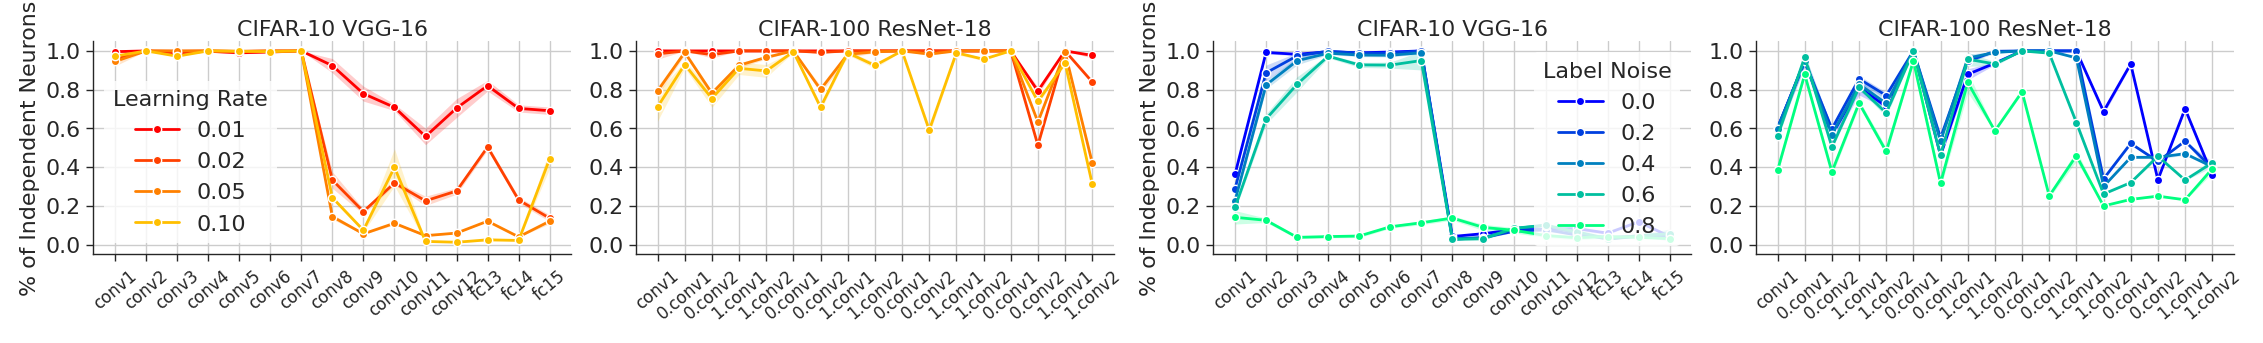

In [163]:

fig, axes = plt.subplots(1,4,figsize=(2.8*4, 1.6), width_ratios=[1, 1, 1, 1])

cmap = matplotlib.cm.get_cmap('autumn', 9)
results=results_cifar_lr

for i,j in enumerate([0.01,0.02,0.05,0.1]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[0].plot(np.arange(15),y.mean(axis=0),marker='o', ms=3, mec="white", mew=0.5,color=cmap(2*i),label='%1.2f'%j)
    axes[0].fill_between(np.arange(15),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=cmap(2*i))
axes[0].set_ylabel(r'% of Independent Neurons')
axes[0].set_ylim(-0.05,1.05)
axes[0].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
axes[0].tick_params(axis='x', which='major', labelsize=6)
axes[0].set_xticklabels(['conv%d'%i for i in range(1,13)]+['fc13','fc14','fc15'],rotation=40)
axes[0].legend(title='Learning Rate', fontsize=8, title_fontsize=8)
axes[0].set_title("CIFAR-10 VGG-16")

cmap = matplotlib.cm.get_cmap('winter', 5)
results=results_cifar_sigma

for i,j in enumerate([0.0,0.2,0.4,0.6,0.8]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[2].plot(np.arange(15),y.mean(axis=0),marker='o', ms=3, mec="white", mew=0.5,color=cmap(i),label='%0.1f'%j)
    axes[2].fill_between(np.arange(15),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=cmap(i))
axes[2].set_ylabel(r'% of Independent Neurons')
axes[2].set_ylim(-0.05,1.05)
axes[2].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
axes[2].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
axes[2].tick_params(axis='x', which='major', labelsize=6)
axes[2].set_xticklabels(['conv%d'%i for i in range(1,13)]+['fc13','fc14','fc15'],rotation=40)
axes[2].legend(title='Label Noise', fontsize=8, title_fontsize=8,loc="upper right")
axes[2].set_title("CIFAR-10 VGG-16")

cmap = matplotlib.cm.get_cmap('autumn', 9)
results=results_cifar100_lr
for i,j in enumerate([0.01,0.02,0.05,0.1]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[1].plot(np.arange(17),y.mean(axis=0),color=cmap(2*i),marker='o', ms=3, mec="white", mew=0.5)
    axes[1].fill_between(np.arange(17),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=cmap(2*i))
axes[1].set_ylim(-0.05,1.05)
axes[1].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
axes[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
axes[1].tick_params(axis='x', which='major', labelsize=6)
axes[1].set_xticklabels(['conv1','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2'],rotation=40)
axes[1].set_title("CIFAR-100 ResNet-18")

cmap = matplotlib.cm.get_cmap('winter', 5)
results=results_cifar100_sigma
for i,j in enumerate([0.0,0.2,0.4,0.6,0.8]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[3].plot(np.arange(17),y.mean(axis=0),color=cmap(i),marker='o', ms=3, mec="white", mew=0.5)
    axes[3].fill_between(np.arange(17),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=cmap(i))
axes[3].set_ylim(-0.05,1.05)
axes[3].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
axes[3].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
axes[3].tick_params(axis='x', which='major', labelsize=6)
axes[3].set_xticklabels(['conv1','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2'],rotation=40)
axes[3].set_title("CIFAR-100 ResNet-18")

plt.savefig('Fig_2.1.pdf',bbox_inches='tight')

/opt/conda/envs/sgdcollapse/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/opt/conda/envs/sgdcollapse/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/opt/conda/envs/sgdcollapse/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


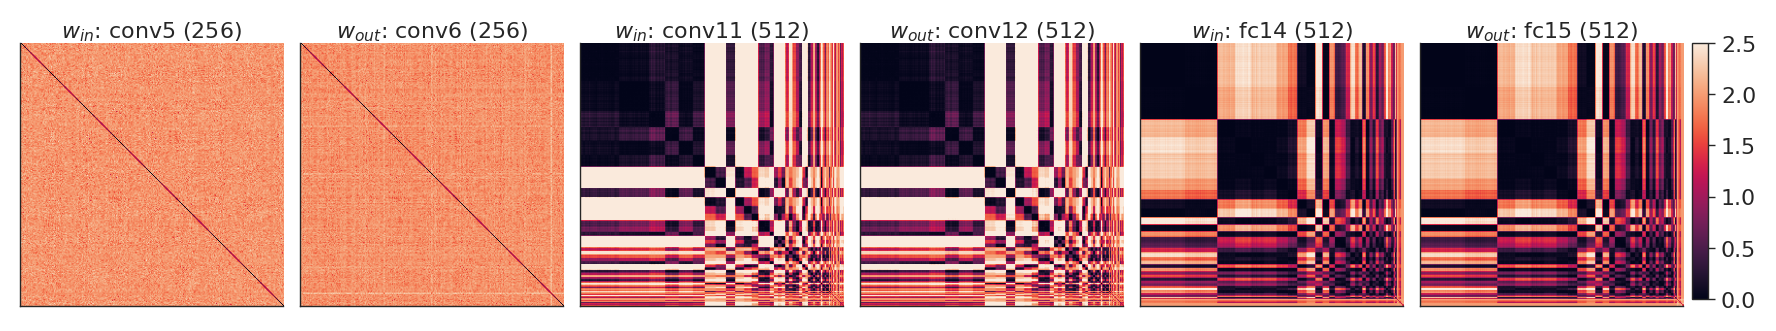

In [9]:
from tqdm import tqdm
meta_results=[]
threshold=0
threshold2=10e-2

exp=TrainExperiment.create('../configs/cifar10_sgd/train_sce_gelu_lbn_final2.yaml',cli_args=False)

exp.optimizer.lr=0.1
exp.optimizer.weight_decay=0.0005
exp.train_batch_size=256
exp.train_data.sigma=0.0
state_dict=torch.load('../exps/'+exp.hash+'/replicate_0/checkpoints/state_100000ba.pt',map_location=torch.device('cpu'))

fig, axes = plt.subplots(1,6,figsize=(2.8*3, 1.6))

layer_i=5

w1=state_dict['state']['model']['module.conv%d.weight'%layer_i].cpu().numpy()
w2=state_dict['state']['model']['module.conv%d.bias'%layer_i].cpu().numpy()
w3=state_dict['state']['model']['module.conv%d.weight'%(layer_i+1)].cpu().numpy()
win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
wout=np.swapaxes(w3,0,1).reshape(w3.shape[1],-1).T
w_cat=np.concatenate([win,wout.T],-1)
tt1=((win[None,:]-win[:,None])**2).sum(axis=-1)/(win[None,:]**2+win[:,None]**2+1e-8).sum(axis=-1)*2
tt2=((wout.T[None,:]-wout.T[:,None])**2).sum(axis=-1)/(wout.T[None,:]**2+wout.T[:,None]**2+1e-8).sum(axis=-1)*2
tt=((w_cat[None,:]-w_cat[:,None])**2).sum(axis=-1)/(w_cat[None,:]**2+w_cat[:,None]**2+1e-8).sum(axis=-1)*2
n_none_ind,dict_list=compute_ind_node(w_cat,threshold2,return_dict=True)
node_order=np.concatenate([list(dict_list.values())[j] for j in np.argsort([len(i) for i in dict_list.values()])[::-1]])
cls=AgglomerativeClustering(n_clusters=n_none_ind,affinity='precomputed',linkage='average')
lbs=cls.fit_predict(tt)
node_order=np.concatenate([np.where(lbs==i)[0] for i in np.argsort([len(np.where(lbs==i)[0]) for i in range(512)])[::-1]])
ii=0
axes[ii].imshow(tt1[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{in}$: '+'conv%d (256)'%(layer_i))
ii=1
axes[ii].imshow(tt2[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{out}$: '+'conv%d (256)'%(layer_i+1))

layer_i=11
w1=state_dict['state']['model']['module.conv%d.weight'%layer_i].cpu().numpy()
w2=state_dict['state']['model']['module.conv%d.bias'%layer_i].cpu().numpy()
w3=state_dict['state']['model']['module.conv%d.weight'%(layer_i+1)].cpu().numpy()
win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
wout=np.swapaxes(w3,0,1).reshape(w3.shape[1],-1).T
w_cat=np.concatenate([win,wout.T],-1)
tt1=((win[None,:]-win[:,None])**2).sum(axis=-1)/(win[None,:]**2+win[:,None]**2+1e-8).sum(axis=-1)*2
tt2=((wout.T[None,:]-wout.T[:,None])**2).sum(axis=-1)/(wout.T[None,:]**2+wout.T[:,None]**2+1e-8).sum(axis=-1)*2
tt=((w_cat[None,:]-w_cat[:,None])**2).sum(axis=-1)/(w_cat[None,:]**2+w_cat[:,None]**2+1e-8).sum(axis=-1)*2
n_none_ind,dict_list=compute_ind_node(w_cat,threshold2,return_dict=True)
node_order=np.concatenate([list(dict_list.values())[j] for j in np.argsort([len(i) for i in dict_list.values()])[::-1]])
cls=AgglomerativeClustering(n_clusters=n_none_ind,affinity='precomputed',linkage='average')
lbs=cls.fit_predict(tt)
node_order=np.concatenate([np.where(lbs==i)[0] for i in np.argsort([len(np.where(lbs==i)[0]) for i in range(512)])[::-1]])
ii=2
axes[ii].imshow(tt1[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{in}$: '+'conv%d (512)'%(layer_i))
ii=3
axes[ii].imshow(tt2[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{out}$: '+'conv%d (512)'%(layer_i+1))

layer_i=14
w1=state_dict['state']['model']['module.fc%d.weight'%layer_i].cpu().numpy()
w2=state_dict['state']['model']['module.fc%d.bias'%layer_i].cpu().numpy()
w3=state_dict['state']['model']['module.fc%d.weight'%(layer_i+1)].cpu().numpy()
win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
wout=w3
w_cat=np.concatenate([win,wout.T],-1)
tt=((w_cat[None,:]-w_cat[:,None])**2).sum(axis=-1)/(w_cat[None,:]**2+w_cat[:,None]**2+1e-8).sum(axis=-1)*2
tt1=((win[None,:]-win[:,None])**2).sum(axis=-1)/(win[None,:]**2+win[:,None]**2+1e-8).sum(axis=-1)*2
tt2=((wout.T[None,:]-wout.T[:,None])**2).sum(axis=-1)/(wout.T[None,:]**2+wout.T[:,None]**2+1e-8).sum(axis=-1)*2
n_none_ind,dict_list=compute_ind_node(w_cat,threshold2,return_dict=True)
node_order=np.concatenate([list(dict_list.values())[j] for j in np.argsort([len(i) for i in dict_list.values()])[::-1]])
cls=AgglomerativeClustering(n_clusters=n_none_ind,affinity='precomputed',linkage='average')
lbs=cls.fit_predict(tt)
node_order=np.concatenate([np.where(lbs==i)[0] for i in np.argsort([len(np.where(lbs==i)[0]) for i in range(512)])[::-1]])
ii=4
axes[ii].imshow(tt1[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{in}$: '+'fc%d (512)'%(layer_i))
ii=5
im=axes[ii].imshow(tt2[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{out}$: '+'fc%d (512)'%(layer_i+1))

cbar_ax = fig.add_axes([1.0, 0.1, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('Fig1.1.pdf',bbox_inches='tight')

/opt/conda/envs/sgdcollapse/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/opt/conda/envs/sgdcollapse/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/opt/conda/envs/sgdcollapse/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


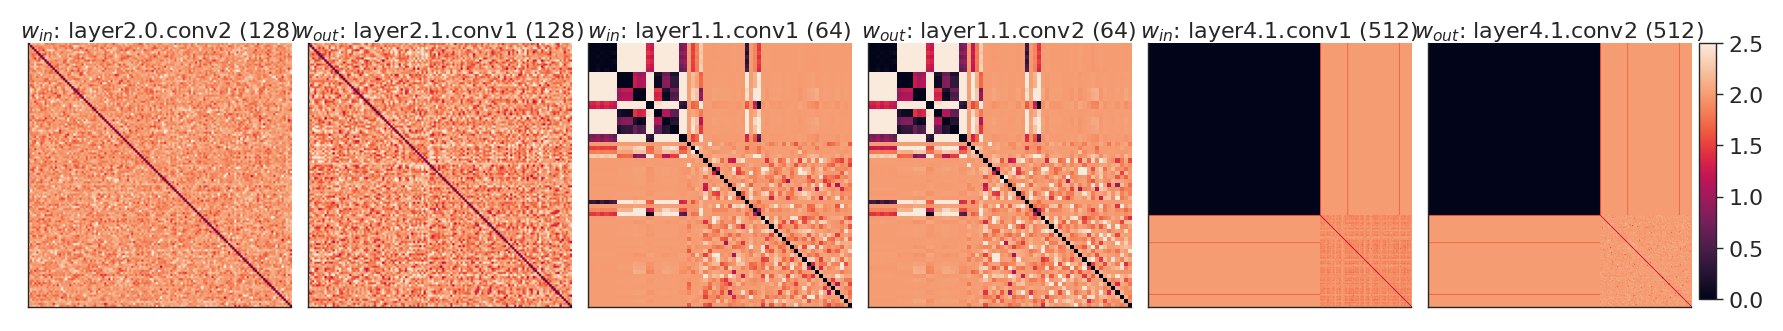

In [12]:
meta_results=[]
threshold=0.0
threshold2=0.1

bn_layer_names=[None,'module.bn1',
                'module.layer1.0.bn1','module.layer1.0.bn2',
                'module.layer1.1.bn1','module.layer1.1.bn2',
                'module.layer2.0.bn1','module.layer2.0.bn2',
                'module.layer2.1.bn1','module.layer2.1.bn2',
                 'module.layer3.0.bn1','module.layer3.0.bn2',
                'module.layer4.1.bn1','module.layer4.1.bn2']
weight_names=['module.conv1.weight',
              'module.layer1.0.conv1.weight','module.layer1.0.conv2.weight',
              'module.layer1.1.conv1.weight','module.layer1.1.conv2.weight',
              'module.layer2.0.conv1.weight','module.layer2.0.conv2.weight',
              'module.layer2.1.conv1.weight','module.layer2.1.conv2.weight',
              'module.layer3.0.conv1.weight','module.layer3.0.conv2.weight',
              'module.layer3.1.conv1.weight','module.layer3.1.conv2.weight',
              'module.layer4.0.conv1.weight','module.layer4.0.conv2.weight',
              'module.layer4.1.conv1.weight','module.layer4.1.conv2.weight','module.fc.weight']

replicate,load_batch=0,1000000

exp=TrainExperiment.create('../configs/cifar100_sgd/train_sce_gelu_resnet.yaml',cli_args=False)
#exp.callbacks[1].save_interval='20000ba'
exp.max_duration='1000000ba'
exp.train_batch_size=256
exp.optimizer.lr=0.02
exp.optimizer.weight_decay=0.0005

state_dict=torch.load('../exps/'+exp.hash+'/replicate_%d/checkpoints/state_%dba.pt'%(replicate,load_batch),map_location=torch.device('cpu'))

names=['conv1','layer1.0.conv1','layer1.0.conv2','layer1.1.conv1','layer1.1.conv2','layer2.0.conv1','layer2.0.conv2','layer2.1.conv1','layer2.1.conv2','layer3.0.conv1','layer3.0.conv2','layer3.1.conv1','layer3.1.conv2','layer4.0.conv1','layer4.0.conv2','layer4.1.conv1','layer4.1.conv2']

fig, axes = plt.subplots(1,6,figsize=(2.8*3.0, 1.6))


layer_i=6
w1=state_dict['state']['model'][weight_names[layer_i]].cpu().numpy()
w2=state_dict['state']['model'][weight_names[layer_i+1]].cpu().numpy()
win=w1.reshape(w1.shape[0],-1)
wout=np.swapaxes(w2,0,1).reshape(w2.shape[1],-1).T
w_cat=np.concatenate([win,wout.T],-1)
tt=((w_cat[None,:]-w_cat[:,None])**2).sum(axis=-1)/(1e-8+w_cat[None,:]**2+w_cat[:,None]**2).sum(axis=-1)*2
tt1=((win[None,:]-win[:,None])**2).sum(axis=-1)/(win[None,:]**2+win[:,None]**2+1e-8).sum(axis=-1)*2
tt2=((wout.T[None,:]-wout.T[:,None])**2).sum(axis=-1)/(wout.T[None,:]**2+wout.T[:,None]**2+1e-8).sum(axis=-1)*2
n_none_ind,dict_list=compute_ind_node(w_cat,threshold2,return_dict=True)
node_order=np.concatenate([list(dict_list.values())[j] for j in np.argsort([len(i) for i in dict_list.values()])[::-1]])
cls=AgglomerativeClustering(n_clusters=n_none_ind,affinity='precomputed',linkage='average')
lbs=cls.fit_predict(tt)
node_order=np.concatenate([np.where(lbs==i)[0] for i in np.argsort([len(np.where(lbs==i)[0]) for i in range(512)])[::-1]])

ii=0
axes[ii].imshow(tt1[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{in}$: '+names[layer_i]+' (128)')
ii=1
axes[ii].imshow(tt2[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{out}$: '+names[layer_i+1]+' (128)')


layer_i=3
w1=state_dict['state']['model'][weight_names[layer_i]].cpu().numpy()
w2=state_dict['state']['model'][weight_names[layer_i+1]].cpu().numpy()
win=w1.reshape(w1.shape[0],-1)
wout=np.swapaxes(w2,0,1).reshape(w2.shape[1],-1).T
w_cat=np.concatenate([win,wout.T],-1)
tt=((w_cat[None,:]-w_cat[:,None])**2).sum(axis=-1)/(1e-8+w_cat[None,:]**2+w_cat[:,None]**2).sum(axis=-1)*2
tt1=((win[None,:]-win[:,None])**2).sum(axis=-1)/(win[None,:]**2+win[:,None]**2+1e-8).sum(axis=-1)*2
tt2=((wout.T[None,:]-wout.T[:,None])**2).sum(axis=-1)/(wout.T[None,:]**2+wout.T[:,None]**2+1e-8).sum(axis=-1)*2
n_none_ind,dict_list=compute_ind_node(w_cat,threshold2,return_dict=True)
node_order=np.concatenate([list(dict_list.values())[j] for j in np.argsort([len(i) for i in dict_list.values()])[::-1]])
cls=AgglomerativeClustering(n_clusters=n_none_ind,affinity='precomputed',linkage='average')
lbs=cls.fit_predict(tt)
node_order=np.concatenate([np.where(lbs==i)[0] for i in np.argsort([len(np.where(lbs==i)[0]) for i in range(512)])[::-1]])

ii=2
axes[ii].imshow(tt1[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{in}$: '+names[layer_i]+' (64)')
ii=3
axes[ii].imshow(tt2[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{out}$: '+names[layer_i+1]+' (64)')

layer_i=15
w1=state_dict['state']['model'][weight_names[layer_i]].cpu().numpy()
w2=state_dict['state']['model'][weight_names[layer_i+1]].cpu().numpy()
win=w1.reshape(w1.shape[0],-1)
wout=np.swapaxes(w2,0,1).reshape(w2.shape[1],-1).T
w_cat=np.concatenate([win,wout.T],-1)
tt=((w_cat[None,:]-w_cat[:,None])**2).sum(axis=-1)/(1e-8+w_cat[None,:]**2+w_cat[:,None]**2).sum(axis=-1)*2
tt1=((win[None,:]-win[:,None])**2).sum(axis=-1)/(win[None,:]**2+win[:,None]**2+1e-8).sum(axis=-1)*2
tt2=((wout.T[None,:]-wout.T[:,None])**2).sum(axis=-1)/(wout.T[None,:]**2+wout.T[:,None]**2+1e-8).sum(axis=-1)*2
n_none_ind,dict_list=compute_ind_node(w_cat,threshold2,return_dict=True)
node_order=np.concatenate([list(dict_list.values())[j] for j in np.argsort([len(i) for i in dict_list.values()])[::-1]])
cls=AgglomerativeClustering(n_clusters=n_none_ind,affinity='precomputed',linkage='average')
lbs=cls.fit_predict(tt)
node_order=np.concatenate([np.where(lbs==i)[0] for i in np.argsort([len(np.where(lbs==i)[0]) for i in range(512)])[::-1]])

ii=4
axes[ii].imshow(tt1[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{in}$: '+names[layer_i]+' (512)')
ii=5
im=axes[ii].imshow(tt2[node_order,:][:,node_order],vmin=0,vmax=2.5)
axes[ii].get_xaxis().set_visible(False)
axes[ii].get_yaxis().set_visible(False)
axes[ii].set_title(r'$w_{out}$: '+names[layer_i+1]+' (512)')

cbar_ax = fig.add_axes([1.0, 0.1, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('Fig1.2.pdf',bbox_inches='tight')